#  Pre-Processing and Modeling

In this notebook we are combining both preporcessing and modeling parts for this project. The total scope of this notebook includes following things. 

* Based on our exploration in previous step we are going to clean and pre-processed before it can be used for model building. This includes removing duplicates, filling in missing values, encoding categorical variables, and scaling or normalizing numerical variables.

* Next step include feature selection, which involves identifying the most important variables that are relevant to predicting loan default. This step is crucial for improving the accuracy of the model and reducing computational complexity.

* After selecting the relevant features, the next step is to choose an appropriate machine learning algorithm to build the predictive model. Some popular algorithms used for this project include logistic regression, decision trees, random forests, and gradient boosting.

* After the model is trained, it will be evaluated on a separate subset of the data to assess its performance. Common metrics used to evaluate model performance include accuracy, precision, recall, and F1 score.

* We will also perform model tuning by adjusting the hyperparameters. 

## Pre-Processing

> Preprocessing is an important step in preparing data for machine learning models. In this step, the collected data is cleaned, transformed, and prepared so that it can be used in machine learning models. In the context of loan default prediction, preprocessing involves several goals to ensure the quality and usefulness of the data. The following are the steps involved in the preprocessing of loan data:

1. Remove or fill any missing data: One of the main goals of preprocessing is to handle any missing data in the dataset. Missing data can result in errors during analysis and can negatively affect the performance of machine learning models. Missing data can be handled by removing the rows or columns that contain missing data, or by filling in the missing data with an appropriate value, such as the mean or median of the other data.

2. Remove unnecessary or repetitive features: Another goal of preprocessing is to remove any features that are not necessary or repetitive. Features that are not relevant to the target variable, or features that are highly correlated with other features, can be removed from the dataset. This step can help to reduce the dimensionality of the dataset, which can improve the performance of machine learning models.

3. Convert categorical string features to dummy variables: Preprocessing also involves converting categorical string features to numerical features that can be used in machine learning models. This can be achieved by creating dummy variables, which are binary variables that represent the different categories of the original feature. Each category is represented by a column in the dataset, and a value of 1 is assigned to the corresponding column for each observation that belongs to that category. This step enables machine learning models to analyze categorical data and can improve the accuracy of the model.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mnso
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
df = pd.read_csv('../data/lending_club_loan_two.csv')
# data shape again
print (f'the shape of data ', df.shape)

the shape of data  (396030, 27)


### Missing values in the data

The dataset contains several columns with null values. To ensure data quality, it is essential to identify the percentage of missing values in each column. This will enable us to decide which columns to drop based on a specific threshold. Prior to conducting the Exploratory Data Analysis, we must perform data cleaning to address the missing values.

In [3]:
df.isnull().sum()


loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [4]:
# Missing values
for column in df.columns:
    if df[column].isna().sum() != 0:
        missing = df[column].isna().sum()
        portion = (missing / df.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1755' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


<AxesSubplot:>

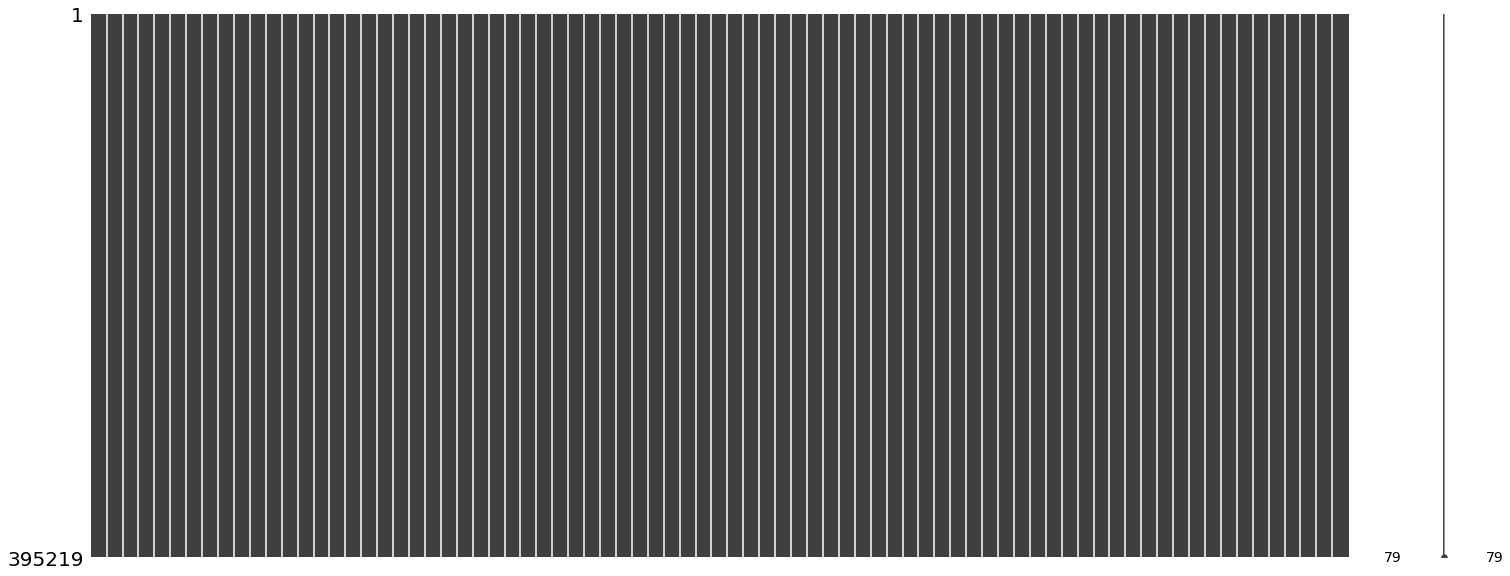

In [52]:
mnso.matrix(df)

> - Highest number of missing values are for `emp_title`, more than 5%. Next most missing values variable is `emp_length`.

#### Dropping the `emp_title` column

In [5]:
# check for emp_title
df['emp_title'].nunique()

173105

> Too many unique value for employement entered by borrower. Since this is categorical variable, it is not realistic to convert all these unique value to dummy variables. So just drop this variable.


In [6]:
df.drop('emp_title', axis=1, inplace=True)

#### Dropping the `title` column

> We are going to check `title` column and `purpose` column and see what is the difference.

In [7]:
df['purpose'].head(10)

0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
5    debt_consolidation
6      home_improvement
7           credit_card
8    debt_consolidation
9    debt_consolidation
Name: purpose, dtype: object

In [8]:
df['title'].head(10)

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object

When checking first 10 values, both `purpose` and `title` column contains same information except `title` shows string format of `purpose` data. Since we have large entries for `title` is missing, I am dropping it here.

In [9]:
df = df.drop('title', axis=1)

#### Dropping the `emp_length` variable

First I am going to check worthiness of `emp_length` i.e its correlation. 

<AxesSubplot:xlabel='emp_length', ylabel='count'>

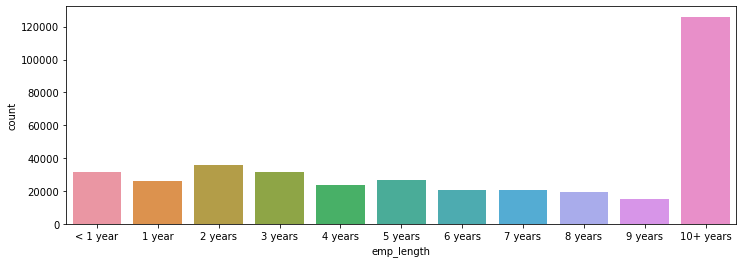

In [10]:
sorted(df["emp_length"].dropna().unique())
emp_length_order = [ '< 1 year',
 '1 year',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '10+ years']
plt.figure(figsize=(12,4))
sns.countplot(x="emp_length",data=df,order=emp_length_order)


<AxesSubplot:xlabel='emp_length', ylabel='count'>

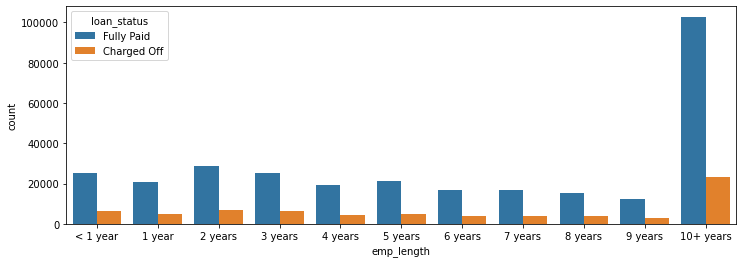

In [11]:
plt.figure(figsize=(12,4))
sns.countplot(x="emp_length",data=df,order=emp_length_order, hue="loan_status")

In above figures we can see that the majority of people are working more than 10 years.

Also, the information provided in the above figure doesn't give us a clear idea of the strength of the relationship between employment length and charge offs. To gain a better understanding, we need to determine the percentage of charge offs in each employment category. This will inform us about the proportion of individuals in each category who were unable to repay their loan. We can achieve this by creating a Series and visualizing it with a bar plot.

<AxesSubplot:xlabel='emp_length'>

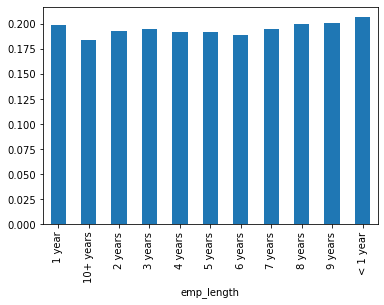

In [12]:
# get percentage of charged off in each emp_length category and plot
ratio_co = df[df["loan_status"]=="Charged Off"].groupby("emp_length").count()["loan_status"]
ratio_fp = df[df["loan_status"]=="Fully Paid"].groupby("emp_length").count()["loan_status"]
ratio_len = ratio_co/(ratio_co+ratio_fp)
ratio_len.plot(kind="bar")

> Variation among all categories is very small and is not directly related to `loan_status`, so we can drop `emp_length` column as well.

In [13]:
df = df.drop('emp_length', axis=1)

#### Most missing values `mort_acc` filled

In our exploratory analysis, we saw `mort_acc` is highly correlated with `total_acc`. So we will fill missing data in `mort_acc` from `total_acc`.

In [14]:
total_acc_avg = df.groupby(by='total_acc').mean().mort_acc

In [15]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [16]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [17]:
# remaining missing values
for column in df.columns:
    if df[column].isna().sum() != 0:
        missing = df[column].isna().sum()
        portion = (missing / df.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


#### Removing missing values of `revol_util` and `pub_rec_bankrupties`

These two features have missing data points, but they account for less than 0.5% of the total data. So we are going to remove the rows that are missing those values in those columns.

In [18]:
df.dropna(inplace=True)

In [19]:
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64

### Removing outlier

### Categorical Variables and Dummpy Variables

In [20]:
df.dtypes

loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
dti                     float64
earliest_cr_line         object
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
address                  object
dtype: object

In [21]:
df.select_dtypes(["object"]).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

> We are going to look in all these string features and see what we can do.

In [22]:
df['term'].value_counts()

 36 months    301247
 60 months     93972
Name: term, dtype: int64

> We see it has two values 36 month and 60 month. We can just change to 36, and 60 as integer.

In [23]:
df["term"] = df["term"].apply(lambda term: int(term[:3]))

In [24]:
df.term.value_counts()

36    301247
60     93972
Name: term, dtype: int64

> `grade` and `sub_grade` feature

We already check in our exploratory analysis that `grade` and `sub-grade` both represent loan grading. So, we are dropping `grade` and keeps only `sub-grade` feature.

Converting the subgrade into dummy variables. Then concatenating these new columns to the original dataframe.

In [25]:
df = df.drop("grade", axis=1)

In [26]:
dummies = pd.get_dummies(df["sub_grade"],drop_first=True)

df = pd.concat([df.drop("sub_grade", axis=1),dummies],axis=1)

In [27]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address', 'A2',
       'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4',
       'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1',
       'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'],
      dtype='object')

> `verification_status`, `application_type`, `initial_list_status` and `purpose` features

Converting these columns: ['verification_status', 'application_type','initial_list_status','purpose'] into dummy variables and concatenate them with the original dataframe. Remember to set drop_first=True and to drop the original columns.

In [28]:
dummies = pd.get_dummies(df[['verification_status', 'application_type','initial_list_status','purpose']],drop_first=True)

df = pd.concat([df.drop(['verification_status', 'application_type','initial_list_status','purpose'], axis=1),dummies],axis=1)

In [29]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'issue_d', 'loan_status', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies', 'address', 'A2', 'A3', 'A4', 'A5',
       'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2',
       'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4',
       'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'initial_list_status_w', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],


> `home_owenership`

In our exploratory analysis, we see home ownership and values None and Any besides Other value. So we will replace these two to Other as well. After this we will convert to dummy variables.

In [30]:
df["home_ownership"] = df["home_ownership"].replace(["NONE","ANY"],"OTHER")

dummies = pd.get_dummies(df["home_ownership"],drop_first=True)

df = pd.concat([df.drop("home_ownership", axis=1),dummies],axis=1)

In [31]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'issue_d',
       'loan_status', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2',
       'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4',
       'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1',
       'G2', 'G3', 'G4', 'G5', 'verification_status_Source Verified',
       'verification_status_Verified', 'application_type_INDIVIDUAL',
       'application_type_JOINT', 'initial_list_status_w',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'OTHER', 'OWN', 'RENT'],
 

> `address` feature

Let's feature engineer a zip code column from the address in the data set. Creating a column called 'zip_code' that extracts the zip code from the address column.

In [32]:
df["zipcode"] = df["address"].apply(lambda adress : adress[-5:])

In [33]:
df["zipcode"].value_counts()

70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: zipcode, dtype: int64

> There are not much values, we can change to dummy variables for zipcode also. At the end I am dropping the address feature here.

In [34]:
dummies = pd.get_dummies(df["zipcode"],drop_first=True)

df = pd.concat([df.drop("zipcode", axis=1),dummies],axis=1)

In [35]:
df = df.drop("address", axis=1)

> `earliest_cr_line`

In our exploratory analysis, we found this is the historical time stamp that contains month and year in values. We can extract year and change that to numerical values.

In [36]:
df["earliest_cr_line"] = df["earliest_cr_line"].apply(lambda date: int(date[-4:]))

In [37]:
df["earliest_cr_line"].value_counts()


2000    29302
2001    29031
1999    26444
2002    25849
2003    23623
        ...  
1951        3
1950        3
1953        2
1944        1
1948        1
Name: earliest_cr_line, Length: 65, dtype: int64

> `issue_d` feature

drop this variable

In [38]:
df = df.drop("issue_d", axis=1)

In [39]:
df['loan_status'] = df.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [64]:
len(df.columns)

79

In [65]:
# define indepent varible and target variable
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']

### Train Test Split

In [40]:
train, test = train_test_split(df, test_size=0.33, random_state=42)
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [41]:
scaler = MinMaxScaler()

In [42]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Building

> I finished preprocessing which includes cleaning the relevant data to ensure that it is free from errors, inconsistencies, and missing values. The nex step is to select appropriate algorithm that will best fit the classification problem for this project. Here our data inlcudes binary classes as target feature of loan status; charged off and default. It is important to test multiple algorithms and select the best-performing one based on key evaluation metrics such as accuracy, precision, recall, and F1-score.

In [43]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

### Logistic Regression

> Logistic regression is a popular statistical method used for binary classification problems. It is a type of regression analysis that estimates the probability of an event occurring based on one or more predictor variables. The output of a logistic regression model is a probability value that ranges from 0 to 1, which can be interpreted as the likelihood of a given observation belonging to a particular class.

In [68]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

y_train_pred = lr_clf.predict(X_train)
y_test_pred = lr_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

c:\Users\Shankar Adhikari\.conda\envs\ParserEnv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Result:
Accuracy Score: 88.84%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.968068       0.880428  0.888378       0.924248       0.897653
recall         0.446804       0.996395  0.888378       0.721599       0.888378
f1-score       0.611414       0.934829  0.888378       0.773122       0.871265
support    52043.000000  212753.000000  0.888378  264796.000000  264796.000000
_______________________________________________
Confusion Matrix: 
 [[ 23253  28790]
 [   767 211986]]

Test Result:
Accuracy Score: 88.90%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.967616       0.881205     0.889       0.924410       0.898086
recall         0.446782       0.996369     0.889       0.721576       0.889000
f1-score       0.611304       0.935255     0.889 

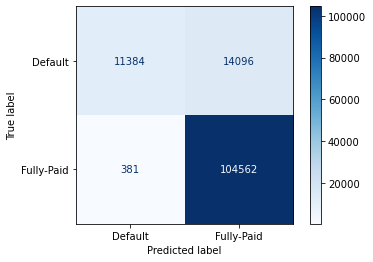

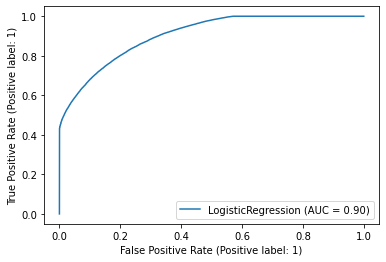

In [69]:
disp = ConfusionMatrixDisplay.from_estimator(
    lr_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)
disp = RocCurveDisplay.from_estimator(lr_clf, X_test, y_test)

In [70]:
scores_dict = {}

In [77]:
scores_dict['Logistic'] = {
        'Train': roc_auc_score(y_train, lr_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, lr_clf.predict(X_test)),
    }

### XGBoost Classifier

> XGBoost, or Extreme Gradient Boosting, is a powerful machine learning algorithm used for classification tasks. It is an ensemble learning method that combines multiple weak learners to create a strong predictive model. XGBoost uses a gradient boosting framework that iteratively trains and adds new decision trees to the model, where each tree is built to correct the errors of the previous tree. This approach results in a highly accurate and robust model that is less prone to overfitting.

In [78]:
# param_grid = dict(
#     n_estimators=stats.randint(10, 500),
#     max_depth=stats.randint(1, 10),
#     learning_rate=stats.uniform(0, 1)
# )

xgb_clf = XGBClassifier(use_label_encoder=False)
# xgb_cv = RandomizedSearchCV(
#     xgb_clf, param_grid, cv=3, n_iter=60, 
#     scoring='roc_auc', n_jobs=-1, verbose=1
# )
# xgb_cv.fit(X_train, y_train)

# best_params = xgb_cv.best_params_
# best_params['tree_method'] = 'gpu_hist'
# # best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
# print(f"Best Parameters: {best_params}")

# xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

c:\Users\Shankar Adhikari\.conda\envs\ParserEnv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train Result:
Accuracy Score: 89.61%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.942634       0.890686  0.896124       0.916660       0.900896
recall         0.502027       0.992527  0.896124       0.747277       0.896124
f1-score       0.655140       0.938853  0.896124       0.796997       0.883092
support    52043.000000  212753.000000  0.896124  264796.000000  264796.000000
_______________________________________________
Confusion Matrix: 
 [[ 26127  25916]
 [  1590 211163]]

Test Result:
Accuracy Score: 88.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.912330       0.886829  0.889452       0.899580       0.891811
recall         0.480298       0.988794  0.889452       0.734546       0.889452
f1-score       0.629300       0.935040  0.889452 

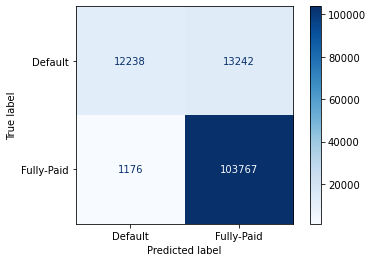

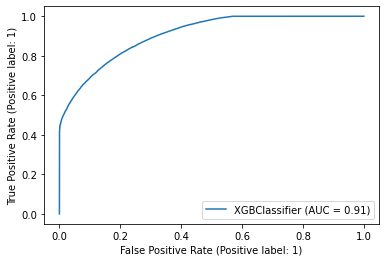

In [85]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)
disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [80]:
scores_dict['XGBoost'] = {
        'Train': roc_auc_score(y_train, xgb_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, xgb_clf.predict(X_test)),
    }

### Random Forest Classifier

> Random Forest Classifier is an ensemble learning method that combines multiple decision trees to improve the accuracy and reduce the variance of the model. In a random forest, each tree is built using a randomly sampled subset of the training data and a randomly selected subset of the features. This helps to prevent overfitting and makes the model more robust to noise and outliers in the data. Random Forest Classifier is known for its high performance, scalability, and interpretability. It can handle large datasets with high dimensionality and is less sensitive to the choice of hyperparameters compared to other machine learning models. Additionally, it can provide useful insights into the relative importance of the input features in predicting the outcome.

In [81]:
# param_grid = dict(
#     n_estimators=stats.randint(100, 1500),
#     max_depth=stats.randint(10, 100),
#     min_samples_split=stats.randint(1, 10),
#     min_samples_leaf=stats.randint(1, 10),
# )

rf_clf = RandomForestClassifier(n_estimators=100)
# rf_cv = RandomizedSearchCV(
#     rf_clf, param_grid, cv=3, n_iter=60, 
#     scoring='roc_auc', n_jobs=-1, verbose=1
# )
# rf_cv.fit(X_train, y_train)
# best_params = rf_cv.best_params_
# print(f"Best Parameters: {best_params}")
# rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      1.000000       0.999991  0.999992       0.999995       0.999992
recall         0.999962       1.000000  0.999992       0.999981       0.999992
f1-score       0.999981       0.999995  0.999992       0.999988       0.999992
support    52043.000000  212753.000000  0.999992  264796.000000  264796.000000
_______________________________________________
Confusion Matrix: 
 [[ 52041      2]
 [     0 212753]]

Test Result:
Accuracy Score: 88.89%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.954286       0.882224  0.888908       0.918255       0.896302
recall         0.453061       0.994730  0.888908       0.723896       0.888908
f1-score       0.614418       0.935105  0.888908

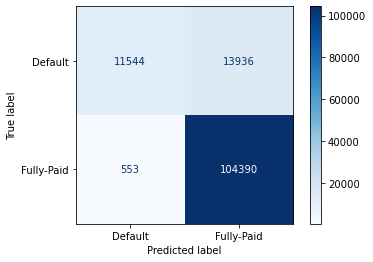

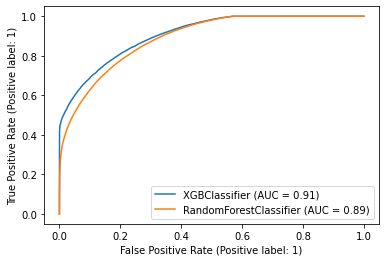

In [82]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'Fully-Paid'])

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)

## Conclusion